In [ ]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
!pip install catboost
import catboost
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import shap

#mount google drive
from google.colab import drive
drive.mount('/content/drive')

# set paths for preprocessor
sys.path.append('/content/drive/MyDrive/Erdos/Project/summer-2025-hoax-detection/')

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from feature_engineer import (
    VandalismScorer,
    is_IP,
    account_age,
    comment_empty,
    word_count,
)

from feature_engineer import preprocessor

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#optuna
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 15.5 MB/s eta 0:00:00


In [18]:
from feature_engineer import VandalismScorer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


In [ ]:
#read the dataset
df = pd.read_csv("/content/drive/MyDrive/Erdos/Project/summer-2025-hoax-detection/Data/train.csv")
preprocessor(df)

In [20]:
scorer = VandalismScorer(n_splits=5, random_state=42)
scorer.fit(df, df['isvandalism'])

VandalismScorer(n_splits=5)

In [21]:
df_transformed = scorer.transform(df)
df_transformed

,EditType,EditID,comment,user,user_edit_count,user_distinct_pages,user_warns,user_reg_time,prev_user,common,...,deleted_lines,isvandalism,num_edits_5d_before,is_person,comment_empty,account_age,is_IP,word_count_added,word_count_deleted,vandalism_score
0,change,329595189,,Nryan30,66,13,0,1259891940,219.78.124.42,,...,,False,1,0,True,0,False,131,1,3.058659e-22
1,change,232199357,/* Penis */,89.242.200.212,4,2,2,20080815230001,66.75.235.255,,...,"""Falcon gained media attention after appearing...",True,4,1,False,1,True,4,202,9.847715e-01
2,change,329877752,Reverted edits by [[Special:Contributions/71.2...,Chamal N,18697,0,2,1208605428,71.208.113.72,,...,""".nmbhgsdj;kfhds;akjfhds;fkjhsf;kjdshf;sdkjhfd...",False,3,0,False,595,False,34,50,2.561915e-01
3,change,253129486,,Animaldudeyay1009,3,1,2,1227241317,J.delanoy,,...,"""A '''kaleidoscope''' is a tube of [[mirror]]s...",True,2,0,True,0,False,94,836,1.000000e+00
4,change,394520551,Adding Persondata using [[Project:AWB|AWB]] (7...,RjwilmsiBot,1602950,1309238,0,1257977968,LobãoV,,...,",",False,0,1,False,356,False,34,0,1.318829e-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25482,change,327368981,Reverted 1 edit by [[Special:Contributions/68....,TreyGeek,15458,4978,2,1203859836,68.40.112.72,,...,* [[Onassis Parungao]] vs. [[Francesco Maturi]...,False,1,0,False,637,False,26,26,5.000000e-01
25484,change,234810735,/* History */,59.180.151.222,1,1,0,20080828164140,68.50.79.137,,...,"""In the past, droughts have periodically led t...",True,0,0,False,1,True,86,79,9.628356e-01
25485,change,329132348,/* In Tamil Nadu */,66.184.61.179,1,1,0,20091201230141,RJFJR,,...,"""[[Tamil Nadu]] is home to one of the oldest a...",False,0,0,False,1,True,340,337,3.401184e-03
25486,change,240599711,/* Biography */,75.157.130.175,6,1,2,20080924030549,J.delanoy,,...,"== Biography ==,""Paulo Coelho was born in [[Ri...",True,11,1,False,1,True,2,209,9.937566e-01


In [ ]:
model_pipe = Pipeline([('scorer', VandalismScorer(n_splits = 5)), ('catboost', CatBoostClassifier(random_state=42))])

In [ ]:
def train(
    predictor: pd.DataFrame,
    target: pd.Series,
    cv: StratifiedKFold,
    scoring: str = "accuracy",
) -> None:

    baseline_model = CatBoostClassifier(random_state=42)
    baseline_score = cross_val_score(
        baseline_model, predictor, target, cv=cv, scoring=scoring
    ).mean()
    print(f"Baseline {scoring} score: {baseline_score:.4f}")

    def objective(trial):
        params = {
            "depth": trial.suggest_int("depth", 3, 10),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "iterations": trial.suggest_int("iterations", 100, 1000),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "border_count": trial.suggest_int("border_count", 32, 255),
            "verbose": 0,
            "random_state": 42,
        }

        model = CatBoostClassifier(**params)
        score = cross_val_score(model, predictor, target, cv=cv, scoring=scoring).mean()

        return score

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=200)

    print("Optuna Optimization Results")
    print("Best Accuracy:", study.best_value)
    print("Best hyperparameters:", study.best_params)

    return study.best_params, study.best_value


def shap_rfe(
    predictor: pd.DataFrame,
    target: pd.Series,
    cv,
    scoring: str = "accuracy",
    drop_threshold: float = 0.01,
    min_features: int = 1,
) -> tuple[float, list[str]]:
    features = predictor.columns.tolist()
    model = CatBoostClassifier(random_state=42, verbosity=0)
    initial_score = cross_val_score(
        model, predictor, target, cv=cv, scoring=scoring
    ).mean()

    performance = [(len(features), initial_score)]
    print(f"Start: {len(features)} features → {scoring}: {initial_score:.4f}")

    best_score = initial_score
    best_features = features.copy()

    while len(features) > min_features:
        model = CatBoostClassifier(random_state=42, verbosity=0)
        model.fit(predictor[features], target)

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(predictor[features])

        mean_shap = np.abs(shap_values).mean(axis=0)
        shap_df = pd.DataFrame({"feature": features, "mean_shap": mean_shap})
        shap_df = shap_df.sort_values(by="mean_shap")

        feature_to_drop = shap_df.iloc[0]["feature"]
        features.remove(feature_to_drop)

        score = cross_val_score(
            CatBoostClassifier(random_state=42, verbosity=0),
            predictor[features],
            target,
            cv=cv,
            scoring=scoring,
        ).mean()

        if score > best_score:
            best_score = score
            best_features = features.copy()

        performance.append((len(features), score))

        if best_score - score > drop_threshold:
            break

    lengths, scores = zip(*performance)
    plt.figure(figsize=(10, 6))
    plt.plot(lengths, scores, marker="o")
    plt.xlabel("Number of Features")
    plt.ylabel(scoring.capitalize())
    plt.title("RFE Performance vs. Number of Features")
    plt.gca().invert_xaxis()
    plt.grid(True)
    plt.show()

    return best_score, best_features

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
target = ["isvandalism"]

In [ ]:
features_1 = [
    "user_edit_count",
    "user_distinct_pages",
    "user_warns",
    "num_recent_edits",
    "num_recent_reversions",
    "num_edits_5d_before",
    "account_age",
    "word_count_added",
    "word_count_deleted",
    "vandalism_score",
    "comment_empty",
    "is_IP",
    "current_minor",
    "is_person",
]


best_params, best_score = train(df[features_1], df[target], cv)

Streaming output truncated to the last 5000 lines.
8:	learn: 0.3682104	total: 339ms	remaining: 37.3s
9:	learn: 0.3523139	total: 376ms	remaining: 37.2s
10:	learn: 0.3369205	total: 408ms	remaining: 36.7s
11:	learn: 0.3235414	total: 445ms	remaining: 36.7s
12:	learn: 0.3114880	total: 484ms	remaining: 36.7s
13:	learn: 0.3015751	total: 542ms	remaining: 38.2s
14:	learn: 0.2922879	total: 570ms	remaining: 37.4s
15:	learn: 0.2838699	total: 604ms	remaining: 37.1s
16:	learn: 0.2763836	total: 646ms	remaining: 37.4s
17:	learn: 0.2696763	total: 687ms	remaining: 37.5s
18:	learn: 0.2637630	total: 733ms	remaining: 37.9s
19:	learn: 0.2585173	total: 758ms	remaining: 37.1s
20:	learn: 0.2532327	total: 786ms	remaining: 36.7s
21:	learn: 0.2492398	total: 802ms	remaining: 35.7s
22:	learn: 0.2451785	total: 832ms	remaining: 35.3s
23:	learn: 0.2411373	total: 863ms	remaining: 35.1s
24:	learn: 0.2375633	total: 913ms	remaining: 35.6s
25:	learn: 0.2348139	total: 934ms	remaining: 35s
26:	learn: 0.2324582	total: 959ms	r

In [ ]:
best_params, best_score

({'depth': 5,
  'l2_leaf_reg': 8.061754574494673,
  'learning_rate': 0.019621131895883232,
  'iterations': 990,
  'subsample': 0.9962007205377031,
  'random_strength': 0.03634375986260423,
  'bagging_temperature': 0.7549103417429414,
  'border_count': 91},
 0.9273637583031059)

In [ ]:
cols_to_transform = [
    "user_edit_count",
    "user_distinct_pages",
    "user_warns",
    "num_recent_edits",
    "num_recent_reversions",
    "num_edits_5d_before",
    "account_age",
    "word_count_added",
    "word_count_deleted",
]

for col in cols_to_transform:
    df[f"log_{col}"] = np.log1p(df[col])

features_2 = [
    "vandalism_score",
    "comment_empty",
    "is_IP",
    "current_minor",
    "is_person",
    "log_user_edit_count",
    "log_user_distinct_pages",
    "log_user_warns",
    "log_num_recent_edits",
    "log_num_recent_reversions",
    "log_num_edits_5d_before",
    "log_account_age",
    "log_word_count_added",
    "log_word_count_deleted",
]

best_params, best_score = train(df[features_2], df[target], cv)

Streaming output truncated to the last 5000 lines.
5:	learn: 0.4361798	total: 146ms	remaining: 24.3s
6:	learn: 0.4101245	total: 172ms	remaining: 24.5s
7:	learn: 0.3876847	total: 194ms	remaining: 24.1s
8:	learn: 0.3693105	total: 223ms	remaining: 24.6s
9:	learn: 0.3528098	total: 250ms	remaining: 24.7s
10:	learn: 0.3356299	total: 281ms	remaining: 25.3s
11:	learn: 0.3217957	total: 304ms	remaining: 25s
12:	learn: 0.3088005	total: 332ms	remaining: 25.2s
13:	learn: 0.2987168	total: 358ms	remaining: 25.2s
14:	learn: 0.2897482	total: 383ms	remaining: 25.2s
15:	learn: 0.2815327	total: 406ms	remaining: 25s
16:	learn: 0.2743177	total: 432ms	remaining: 25s
17:	learn: 0.2679183	total: 460ms	remaining: 25.1s
18:	learn: 0.2625192	total: 483ms	remaining: 24.9s
19:	learn: 0.2575884	total: 511ms	remaining: 25.1s
20:	learn: 0.2529771	total: 539ms	remaining: 25.1s
21:	learn: 0.2503444	total: 554ms	remaining: 24.6s
22:	learn: 0.2464246	total: 566ms	remaining: 24s
23:	learn: 0.2427273	total: 577ms	remaining:

In [ ]:
features_3 = [
    "user_edit_count",
    "user_distinct_pages",
    "user_warns",
    "num_recent_edits",
    "num_recent_reversions",
    "num_edits_5d_before",
    "account_age",
    "word_count_added",
    "word_count_deleted",
    "vandalism_score",
    "comment_empty",
    "is_IP",
    "current_minor",
    "is_person",
    "log_user_edit_count",
    "log_user_distinct_pages",
    "log_user_warns",
    "log_num_recent_edits",
    "log_num_recent_reversions",
    "log_num_edits_5d_before",
    "log_account_age",
    "log_word_count_added",
    "log_word_count_deleted",
]

best_params, best_score = train(df[features_3], df[target], cv)

Baseline accuracy score: 0.9225
Optuna Optimization Results
Best Accuracy: 0.9272852579680624
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 5, 'gamma': 0.37730678446601834, 'subsample': 0.8799941705248336, 'colsample_bytree': 0.9666039231269101, 'colsample_bylevel': 0.8974341267150372, 'reg_alpha': 2.9678231951953236, 'learning_rate': 0.048585930704550404, 'n_estimators': 566}


Original Features:
Start: 14 features → accuracy: 0.9234


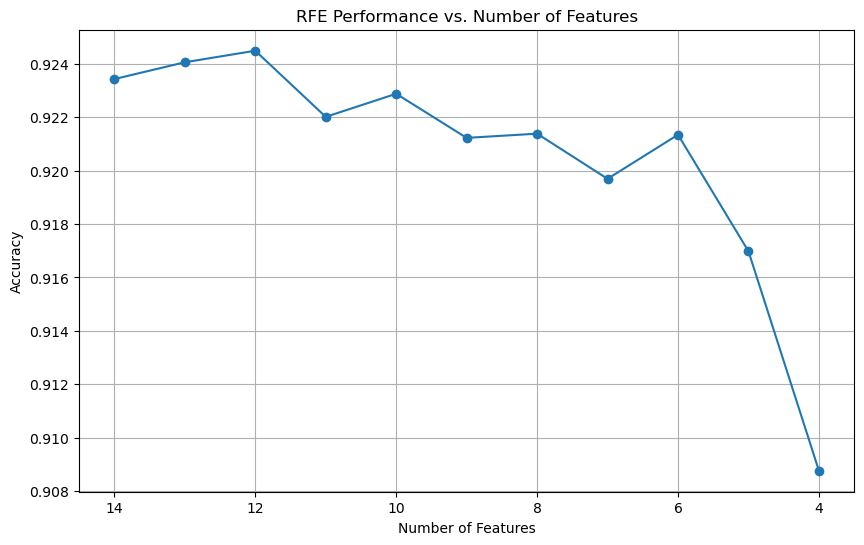


Transformed Features:
Start: 14 features → accuracy: 0.9245


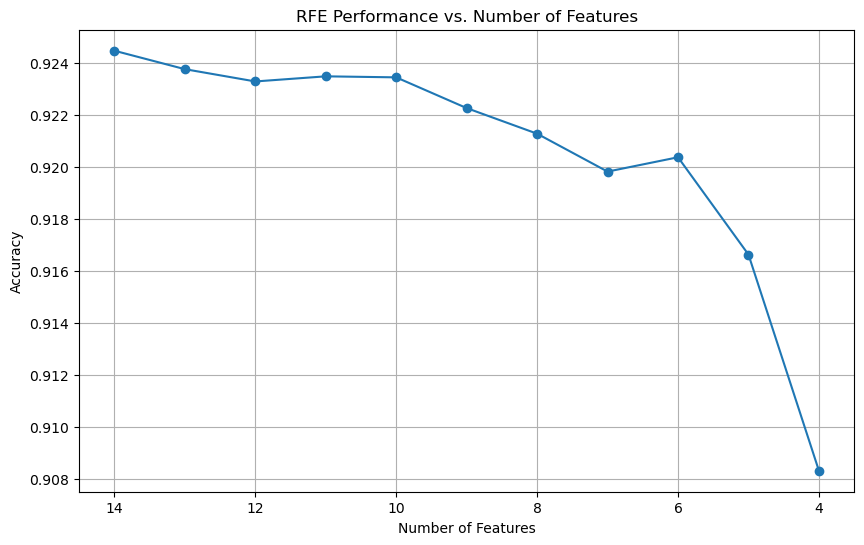


Combined Features:
Start: 23 features → accuracy: 0.9225


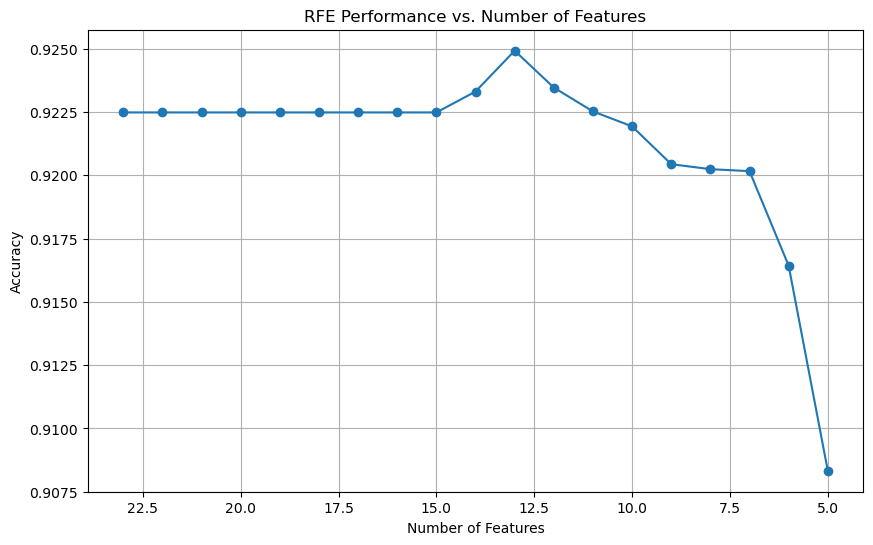

In [ ]:
print("Original Features:")
best_score_1, best_features_1 = shap_rfe(df[features_1], df[target], cv)

print("\nTransformed Features:")
best_score_2, best_features_2 = shap_rfe(df[features_2], df[target], cv)

print("\nCombined Features:")
best_score_3, best_features_3 = shap_rfe(df[features_3], df[target], cv)

In [ ]:
print("Original features:")
print(f"features: {best_features_1}")
print(f"performance: {best_score_1}")

print("\nTransformed features:")
print(f"features: {best_features_2}")
print(f"performance: {best_score_2}")

print("\nCombined features:")
print(f"features: {best_features_3}")
print(f"performance: {best_score_3}")

Original features:
features: ['user_edit_count', 'user_distinct_pages', 'user_warns', 'num_recent_reversions', 'num_edits_5d_before', 'account_age', 'word_count_added', 'word_count_deleted', 'vandalism_score', 'comment_empty', 'is_IP', 'is_person']
performance: 0.9244929319925405

Transformed features:
features: ['vandalism_score', 'comment_empty', 'is_IP', 'current_minor', 'is_person', 'log_user_edit_count', 'log_user_distinct_pages', 'log_user_warns', 'log_num_recent_edits', 'log_num_recent_reversions', 'log_num_edits_5d_before', 'log_account_age', 'log_word_count_added', 'log_word_count_deleted']
performance: 0.9244535696927304

Combined features:
features: ['user_edit_count', 'user_distinct_pages', 'user_warns', 'num_recent_reversions', 'num_edits_5d_before', 'account_age', 'word_count_added', 'word_count_deleted', 'vandalism_score', 'comment_empty', 'is_IP', 'current_minor', 'log_user_edit_count']
performance: 0.9249256543595681


In [ ]:
print("Original features:")
train_params_1, best_score_1 = train(
    df[best_features_1], df[target], cv, scoring="accuracy"
)

print("\nTransformed features:")
train_params_2, best_score_2 = train(
    df[best_features_2], df[target], cv, scoring="accuracy"
)

print("\nCombined features:")
train_params_3, best_score_3 = train(
    df[best_features_3], df[target], cv, scoring="accuracy"
)

Original features:
Baseline accuracy score: 0.9245
Optuna Optimization Results
Best Accuracy: 0.9266558323676424
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 2, 'gamma': 2.6365802330446995, 'subsample': 0.8027883410092592, 'colsample_bytree': 0.9892518341476984, 'colsample_bylevel': 0.6992742978040835, 'reg_alpha': 0.4195802318106978, 'learning_rate': 0.03191555692643836, 'n_estimators': 886}

Transformed features:
Baseline accuracy score: 0.9245
Optuna Optimization Results
Best Accuracy: 0.9267345337674786
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 3.574906090396237, 'subsample': 0.6413166189046338, 'colsample_bytree': 0.8364125062735576, 'colsample_bylevel': 0.7876749416699214, 'reg_alpha': 0.018528602300072756, 'learning_rate': 0.04242271315487732, 'n_estimators': 824}

Combined features:
Baseline accuracy score: 0.9249
Optuna Optimization Results
Best Accuracy: 0.9269705219680686
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 1,